Loading and splitting Preprocessed data

In [41]:
with open ("unstemmed_positive_reviews.txt","r") as f:
    positives = f.readlines()
with open ("unstemmed_negative_reviews.txt","r") as f:
    negatives = f.readlines()

negatives = [x.strip() for x in negatives]
positives = [x.strip() for x in positives]

In [42]:
Xtrain = negatives[:5000]+positives[:5000]
Xtest = positives[5000:5100]+negatives[5000:5100]
ytrain = [0]*5000+[1]*5000
ytest = [1]*100+[0]*100

Downloading stop words

In [43]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Defining the default word based stemming and the porter stemmer

In [44]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

*********************************************************** Logistic Regression ************************************************

Defining the pipeline containing tf-idf vectorization of text and the Logistic Regression classifier. \
Defining the hyperparameter search space and configuring the cross-validation grid search \
Fitting the model to the training 

Hyperparameters: \
ngrams = 1,2 \
stop words = retained & filtered \
tokenizer = default & porter stemmer \
idf weighting = enabled & disabled \
C = [0.1, 1, 10, 100] \
penalty = [l1, l2]

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

stop = stopwords.words('english')

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [
              {'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[True, False],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.1, 1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(solver="saga",random_state=0))])

# lr_tfidf.fit(Xtrain, ytrain)
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

gs_lr_tfidf.fit(Xtrain, ytrain)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


c:\Users\prane\anaconda3\envs\DIS\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\prane\anaconda3\envs\DIS\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.1, 1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 2)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x0000022463C20430>,
                                              <function tokenizer_porter at 0x0000022462B3F040>],
                          'vect__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

Best performing parameters. \
Best validation accuracy

In [46]:
print('Best parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x0000022462B3F040>, 'vect__use_idf': True}
Best accuracy: 0.871


Test accuracy

In [47]:
gs_lr_tfidf.best_estimator_.score(Xtest, ytest)

0.955

Saving results and the model

In [48]:
import pickle
import os

pickle.dump(gs_lr_tfidf.best_estimator_, open('lr.pkl', 'wb'), protocol=4)
pickle.dump(gs_lr_tfidf.cv_results_, open('lr_results.pkl', 'wb'), protocol=4)

Plotting results

In [51]:
logreg_results=gs_lr_tfidf.cv_results_

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [53]:
stop_mask = (logreg_results["param_vect__stop_words"].data == None)
tkn = logreg_results["param_vect__tokenizer"].data
tokenizer_mask = []
for x in tkn:
    if "porter" in x.__name__:
        tokenizer_mask.append(True)
    else:
        tokenizer_mask.append(False)
tokenizer_mask = np.array(tokenizer_mask)
penalty_mask = (logreg_results["param_clf__penalty"].data == "l2")
idf_mask = (logreg_results["param_vect__use_idf"].data == True)

c_l2psi = logreg_results["param_clf__C"].data[stop_mask & penalty_mask & tokenizer_mask & idf_mask]
c_l1psi = logreg_results["param_clf__C"].data[stop_mask & ~penalty_mask & tokenizer_mask & idf_mask]
c_l2npsi = logreg_results["param_clf__C"].data[stop_mask & penalty_mask & ~tokenizer_mask & idf_mask]
c_l2pnsi = logreg_results["param_clf__C"].data[~stop_mask & penalty_mask & tokenizer_mask & idf_mask]
c_l2psni = logreg_results["param_clf__C"].data[stop_mask & penalty_mask & tokenizer_mask & ~idf_mask]
acc_l1psi = logreg_results["mean_test_score"][stop_mask & ~penalty_mask & tokenizer_mask & idf_mask]
acc_l2psi = logreg_results["mean_test_score"][stop_mask & penalty_mask & tokenizer_mask & idf_mask]
acc_l2npsi = logreg_results["mean_test_score"][stop_mask & penalty_mask & ~tokenizer_mask & idf_mask]
acc_l2pnsi = logreg_results["mean_test_score"][~stop_mask & penalty_mask & tokenizer_mask & idf_mask]
acc_l2psni = logreg_results["mean_test_score"][stop_mask & penalty_mask & tokenizer_mask & ~idf_mask]

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

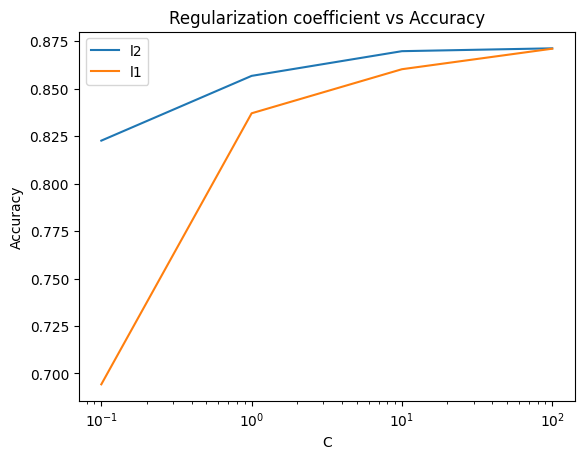

In [54]:
plt.plot(c_l2psi, acc_l2psi, label="l2")
plt.plot(c_l1psi, acc_l1psi, label="l1")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

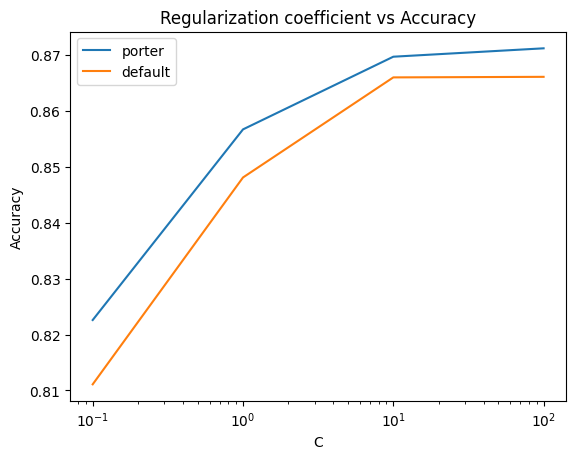

In [55]:
plt.plot(c_l2psi, acc_l2psi, label="porter")
plt.plot(c_l2npsi, acc_l2npsi, label="default")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

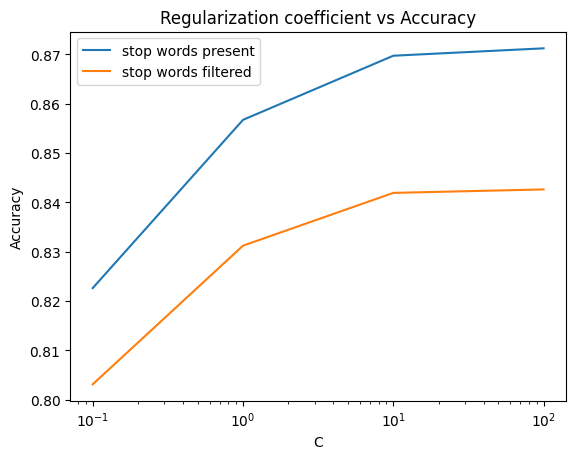

In [56]:
plt.plot(c_l2psi, acc_l2psi, label="stop words present")
plt.plot(c_l2pnsi, acc_l2pnsi, label="stop words filtered")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

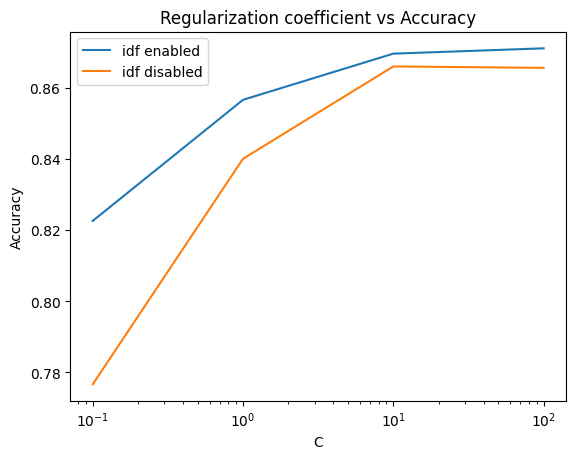

In [57]:
plt.plot(c_l2psi, acc_l2psi, label="idf enabled")
plt.plot(c_l2psni, acc_l2psni, label="idf disabled")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

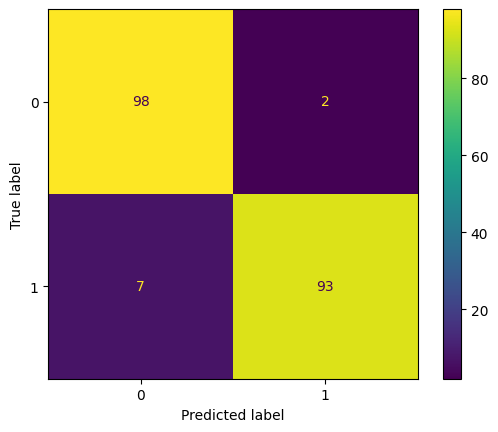

In [61]:
ypreds = gs_lr_tfidf.best_estimator_.predict(Xtest)
cm = confusion_matrix(ytest, ypreds, labels=gs_lr_tfidf.best_estimator_[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=gs_lr_tfidf.best_estimator_[1].classes_)
disp.plot()

*********************************************** MNB ********************************************************

Defining the pipeline containing tf-idf vectorization of text and the Multivariate Naive Bayes classifier. \
Defining the hyperparameter search space and configuring the cross-validation grid search \
Fitting the model to the training data

Hyperparameters: \
ngrams = 1,2 \
stop words = retained & filtered \
tokenizer = default & porter stemmer \
idf weighting = enabled & disabled

In [62]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [
              {'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[True, False],},
              ]

mnb_tfidf = Pipeline([('vect', tfidf),
                     ('clf', MultinomialNB())])

# lr_tfidf.fit(Xtrain, ytrain)
gs_mnb_tfidf = GridSearchCV(mnb_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

gs_mnb_tfidf.fit(Xtrain, ytrain)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\prane\anaconda3\envs\DIS\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vect__ngram_range': [(1, 2)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x0000022463C20430>,
                                              <function tokenizer_porter at 0x0000022462B3F040>],
                          'vect__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

Best performing parameters. \
Best validation accuracy

In [63]:
print('Best parameter set: ' + str(gs_mnb_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_mnb_tfidf.best_score_)

Best parameter set: {'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x0000022462B3F040>, 'vect__use_idf': True}
Best accuracy: 0.844


MNB Test Accuracy

In [64]:
gs_mnb_tfidf.best_estimator_.score(Xtest, ytest)

0.91

Saving model and results

In [65]:
pickle.dump(gs_mnb_tfidf.best_estimator_, open('mnb.pkl', 'wb'), protocol=4)
pickle.dump(gs_mnb_tfidf.cv_results_, open('mnb_results.pkl', 'wb'), protocol=4)

MNB plot results

In [66]:
mnb_results = gs_mnb_tfidf.cv_results_

In [67]:
stop_mask = (mnb_results["param_vect__stop_words"].data == None)
tkn = mnb_results["param_vect__tokenizer"].data
tokenizer_mask = []
for x in tkn:
    if "porter" in x.__name__:
        tokenizer_mask.append(True)
    else:
        tokenizer_mask.append(False)
tokenizer_mask = np.array(tokenizer_mask)
idf_mask = (mnb_results["param_vect__use_idf"].data == True)

In [68]:
ypreds = gs_mnb_tfidf.best_estimator_.predict(Xtest)

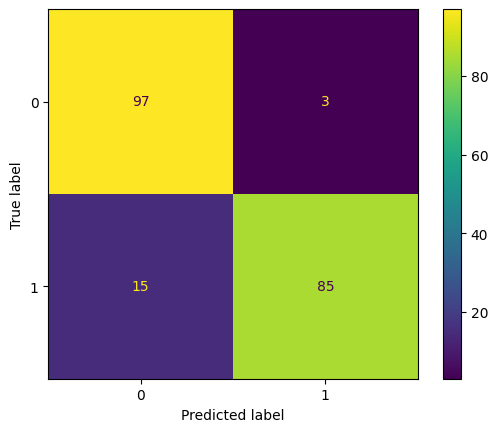

In [40]:
cm = confusion_matrix(ytest, ypreds, labels=gs_mnb_tfidf.best_estimator_[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=gs_mnb_tfidf.best_estimator_[1].classes_)
disp.plot()

********************************* SVM ***********************************

Defining the pipeline containing tf-idf vectorization of text and the Logistic Regression classifier. \
Defining the hyperparameter search space and configuring the cross-validation grid search \
Fitting the model to the training 

Hyperparameters: \
ngrams = 1,2 \
stop words = retained & filtered \
tokenizer = default & porter stemmer \
idf weighting = enabled & disabled \
C = [0.1, 1, 10, 100] \
gamma = [1, 0.1, 0.01, 0.001]

In [69]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [
              {'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[True, False],
               'clf__C': [0.1, 1.0, 10.0, 100.0],
               'clf__gamma': [1, 0.1, 0.01, 0.001]},
              ]

svm_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SVC(random_state=0))])

# lr_tfidf.fit(Xtrain, ytrain)
gs_svm_tfidf = GridSearchCV(svm_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

gs_svm_tfidf.fit(Xtrain, ytrain)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


c:\Users\prane\anaconda3\envs\DIS\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', SVC(random_state=0))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.1, 1.0, 10.0, 100.0],
                          'clf__gamma': [1, 0.1, 0.01, 0.001],
                          'vect__ngram_range': [(1, 2)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x0000022463C20430>,
                                              <function tokenizer_porter at 0x0000022462B3F040>],
                          'vect__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

Best performing estimator and validation accuracy

In [70]:
print('Best parameter set: ' + str(gs_svm_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_svm_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__gamma': 0.1, 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x0000022462B3F040>, 'vect__use_idf': True}
Best accuracy: 0.872


Saving model and results

In [71]:
import pickle
import os

pickle.dump(gs_svm_tfidf.best_estimator_, open('svm.pkl', 'wb'), protocol=4)
pickle.dump(gs_svm_tfidf.cv_results_, open('svm_results.pkl', 'wb'), protocol=4)

SVM Test Accuracy

In [72]:
gs_svm_tfidf.best_estimator_.score(Xtest,ytest)

0.96

SVM plot results

In [73]:
svm_results = gs_svm_tfidf.cv_results_

In [74]:
stop_mask = (svm_results["param_vect__stop_words"].data == None)
tkn = svm_results["param_vect__tokenizer"].data
tokenizer_mask = []
for x in tkn:
    if "porter" in x.__name__:
        tokenizer_mask.append(True)
    else:
        tokenizer_mask.append(False)
tokenizer_mask = np.array(tokenizer_mask)
idf_mask = (svm_results["param_vect__use_idf"].data == True)
g1_mask = (svm_results["param_clf__gamma"].data == 1)
g2_mask = (svm_results["param_clf__gamma"].data == 0.1)
g3_mask = (svm_results["param_clf__gamma"].data == 0.01)
g4_mask = (svm_results["param_clf__gamma"].data == 0.001)

c_g1psi = svm_results["param_clf__C"].data[stop_mask & g1_mask & tokenizer_mask & idf_mask]
c_g2psi = svm_results["param_clf__C"].data[stop_mask & g2_mask & tokenizer_mask & idf_mask]
c_g3psi = svm_results["param_clf__C"].data[stop_mask & g3_mask & tokenizer_mask & idf_mask]
c_g4psi = svm_results["param_clf__C"].data[stop_mask & g4_mask & tokenizer_mask & idf_mask]
c_g2npsi = svm_results["param_clf__C"].data[stop_mask & g2_mask & ~tokenizer_mask & idf_mask]
c_g2pnsi = svm_results["param_clf__C"].data[~stop_mask & g2_mask & tokenizer_mask & idf_mask]
c_g2psni = svm_results["param_clf__C"].data[stop_mask & g2_mask & tokenizer_mask & ~idf_mask]
acc_g1psi = svm_results["mean_test_score"][stop_mask & g1_mask & tokenizer_mask & idf_mask]
acc_g2psi = svm_results["mean_test_score"][stop_mask & g2_mask & tokenizer_mask & idf_mask]
acc_g3psi = svm_results["mean_test_score"][stop_mask & g3_mask & tokenizer_mask & idf_mask]
acc_g4psi = svm_results["mean_test_score"][stop_mask & g4_mask & tokenizer_mask & idf_mask]
acc_g2npsi = svm_results["mean_test_score"][stop_mask & g2_mask & ~tokenizer_mask & idf_mask]
acc_g2pnsi = svm_results["mean_test_score"][~stop_mask & g2_mask & tokenizer_mask & idf_mask]
acc_g2psni = svm_results["mean_test_score"][stop_mask & g2_mask & tokenizer_mask & ~idf_mask]

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

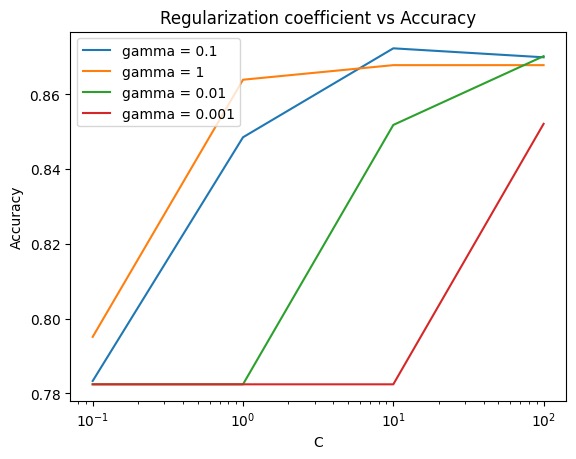

In [75]:
plt.plot(c_g2psi, acc_g2psi, label="gamma = 0.1")
plt.plot(c_g1psi, acc_g1psi, label="gamma = 1")
plt.plot(c_g3psi, acc_g3psi, label="gamma = 0.01")
plt.plot(c_g4psi, acc_g4psi, label="gamma = 0.001")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

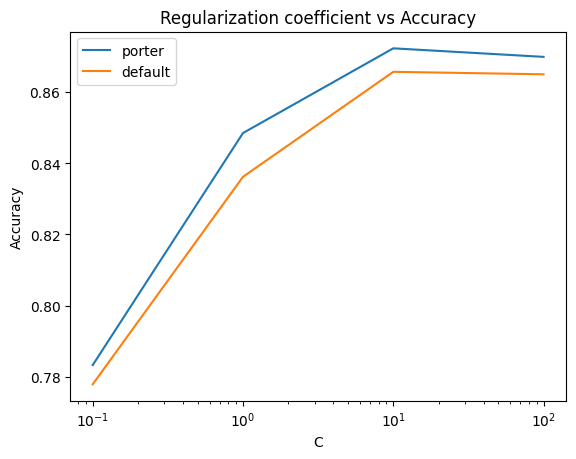

In [76]:
plt.plot(c_g2psi, acc_g2psi, label="porter")
plt.plot(c_g2npsi, acc_g2npsi, label="default")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

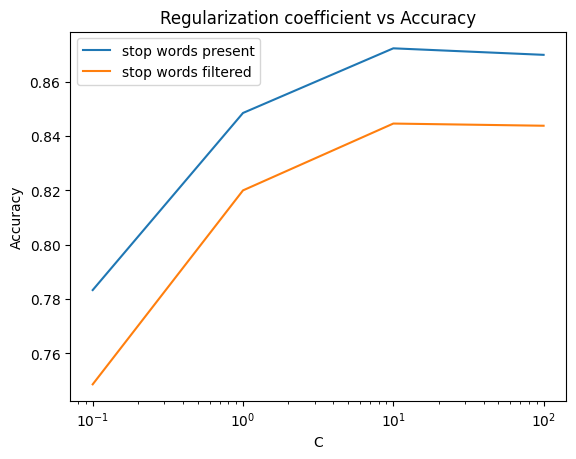

In [77]:
plt.plot(c_g2psi, acc_g2psi, label="stop words present")
plt.plot(c_g2pnsi, acc_g2pnsi, label="stop words filtered")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

Text(0.5, 1.0, 'Regularization coefficient vs Accuracy')

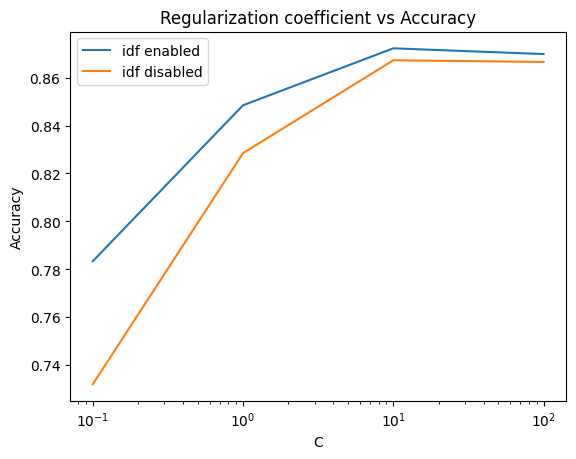

In [78]:
plt.plot(c_g2psi, acc_g2psi, label="idf enabled")
plt.plot(c_g2psni, acc_g2psni, label="idf disabled")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization coefficient vs Accuracy")

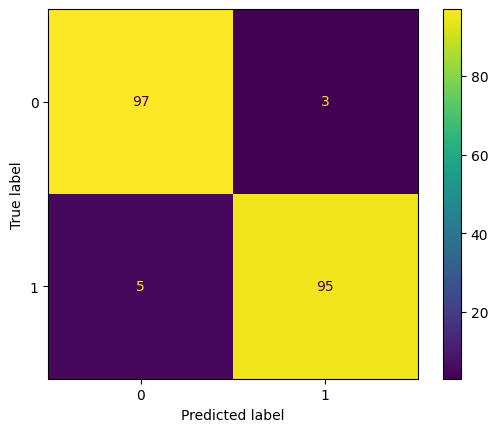

In [79]:
ypreds = gs_svm_tfidf.best_estimator_.predict(Xtest)
cm = confusion_matrix(ytest, ypreds, labels=gs_svm_tfidf.best_estimator_[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=gs_svm_tfidf.best_estimator_[1].classes_)
disp.plot()

************************** KNN **************************

Defining the pipeline containing tf-idf vectorization of text and the Logistic Regression classifier. \
Defining the hyperparameter search space and configuring the cross-validation grid search \
Fitting the model to the training 

Hyperparameters: \
ngrams = 1,2 \
stop words = retained & filtered \
tokenizer = default & porter stemmer \
idf weighting = enabled & disabled \
C = [1, 2, 3, 4, 5 ,6 ,7 ,8, 9] \

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,
)

param_grid = [
              {'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[True, False],
               'clf__n_neighbors': list(range(1,10)),
              #  'clf__p': [1.0,2.0]
              },
              ]

knn_tfidf = Pipeline([('vect', tfidf),
                     ('clf', KNeighborsClassifier(weights="distance"))])

# lr_tfidf.fit(Xtrain, ytrain)
gs_knn_tfidf = GridSearchCV(knn_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5, 
                           verbose=1,
                           n_jobs=-1)

gs_knn_tfidf.fit(Xtrain, ytrain)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\prane\anaconda3\envs\DIS\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=-1,
             param_grid=[{'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'vect__ngram_range': [(1, 2)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x0000022463C20430>,
                                              <function tokenizer_porter at 0x0000022462B3F040>],
                          'vect__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

Best performing estimator and validation accuracy

In [86]:
print('Best parameter set: ' + str(gs_knn_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_knn_tfidf.best_score_)

Best parameter set: {'clf__n_neighbors': 9, 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x0000022463C20430>, 'vect__use_idf': False}
Best accuracy: 0.541


Save model and results

In [87]:
import pickle
import os

pickle.dump(gs_knn_tfidf.best_estimator_, open('knn.pkl', 'wb'), protocol=4)
pickle.dump(gs_knn_tfidf.cv_results_, open('knn_results.pkl', 'wb'), protocol=4)

KNN test accuracy

In [88]:
gs_knn_tfidf.best_estimator_.score(Xtest,ytest)

0.515

Plot KNN results

In [90]:
knn_results = gs_knn_tfidf.cv_results_

In [91]:
stop_mask = (knn_results["param_vect__stop_words"].data == None)
tkn = knn_results["param_vect__tokenizer"].data
tokenizer_mask = []
for x in tkn:
    if "porter" in x.__name__:
        tokenizer_mask.append(True)
    else:
        tokenizer_mask.append(False)
tokenizer_mask = np.array(tokenizer_mask)
idf_mask = (knn_results["param_vect__use_idf"].data == True)

kpsi = knn_results["param_clf__n_neighbors"].data[stop_mask & tokenizer_mask & idf_mask]
knpsi = knn_results["param_clf__n_neighbors"].data[stop_mask & ~tokenizer_mask & idf_mask]
kpnsi = knn_results["param_clf__n_neighbors"].data[~stop_mask & tokenizer_mask & idf_mask]
kpsni = knn_results["param_clf__n_neighbors"].data[stop_mask & tokenizer_mask & ~idf_mask]
acc_kpsi = knn_results["mean_test_score"][stop_mask & tokenizer_mask & idf_mask]
acc_knpsi = knn_results["mean_test_score"][stop_mask & ~tokenizer_mask & idf_mask]
acc_kpnsi = knn_results["mean_test_score"][~stop_mask & tokenizer_mask & idf_mask]
acc_kpsni = knn_results["mean_test_score"][stop_mask & tokenizer_mask & ~idf_mask]

Text(0.5, 1.0, 'K vs Accuracy')

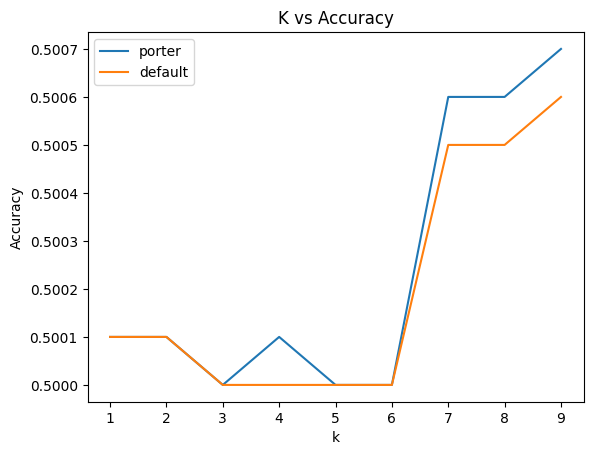

In [92]:
plt.plot(kpsi, acc_kpsi, label="porter")
plt.plot(kpsi, acc_knpsi, label="default")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.title("K vs Accuracy")

Text(0.5, 1.0, 'K vs Accuracy')

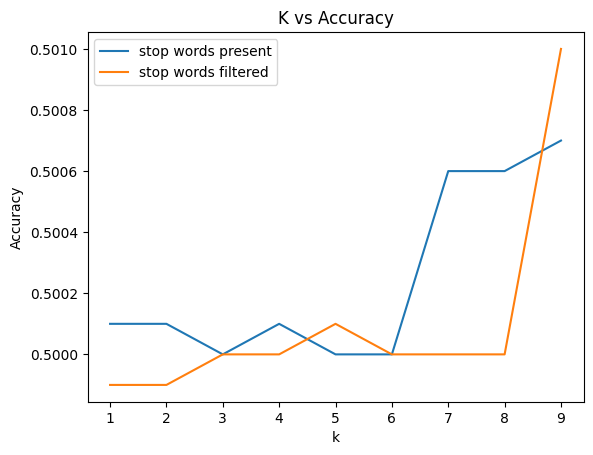

In [93]:
plt.plot(kpsi, acc_kpsi, label="stop words present")
plt.plot(kpsi, acc_kpnsi, label="stop words filtered")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.title("K vs Accuracy")

Text(0.5, 1.0, 'K vs Accuracy')

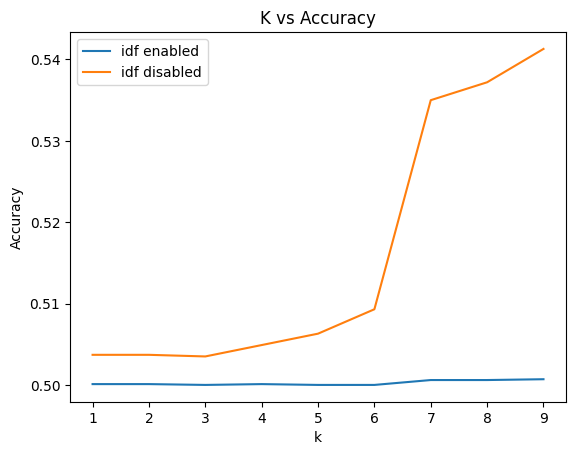

In [94]:
plt.plot(kpsi, acc_kpsi, label="idf enabled")
plt.plot(kpsi, acc_kpsni, label="idf disabled")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.title("K vs Accuracy")

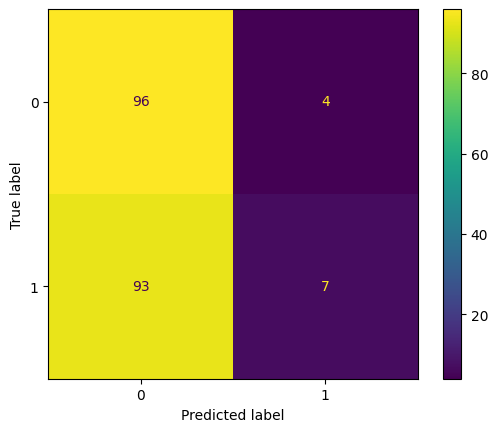

In [95]:
ypreds = gs_knn_tfidf.best_estimator_.predict(Xtest)
cm = confusion_matrix(ytest, ypreds, labels=gs_knn_tfidf.best_estimator_[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=gs_knn_tfidf.best_estimator_[1].classes_)
disp.plot()